<a href="https://colab.research.google.com/github/cgyireh1/Sound_Clustering/blob/main/sound_clustering_formative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make allNecessary Imports
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/MyModels/clustering/unlabelled_sounds"

In [12]:
features = []
# Extract the Features from the audios
for file in os.listdir(unlabelled_data_path):
    file_path = os.path.join(unlabelled_data_path, file)
    y, sr = librosa.load(file_path, sr=None)  # sr = sampling rate
    # Computing the Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    features.append(np.mean(log_mel_spectrogram, axis=1))

features_array = np.array(features)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

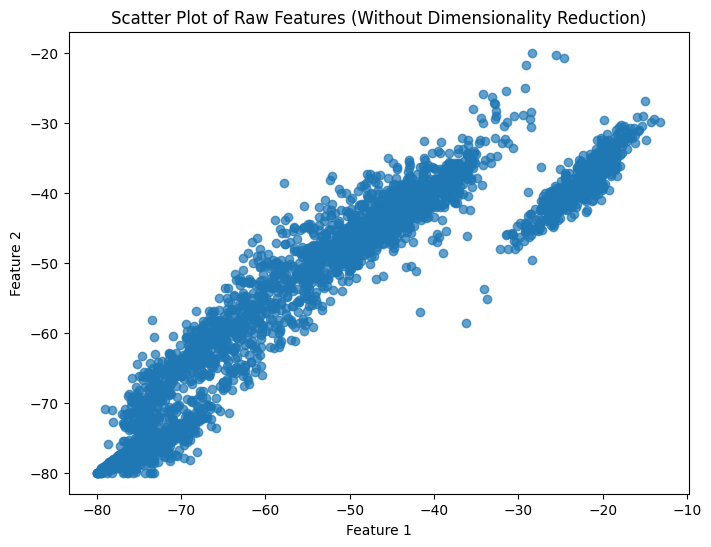

In [14]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

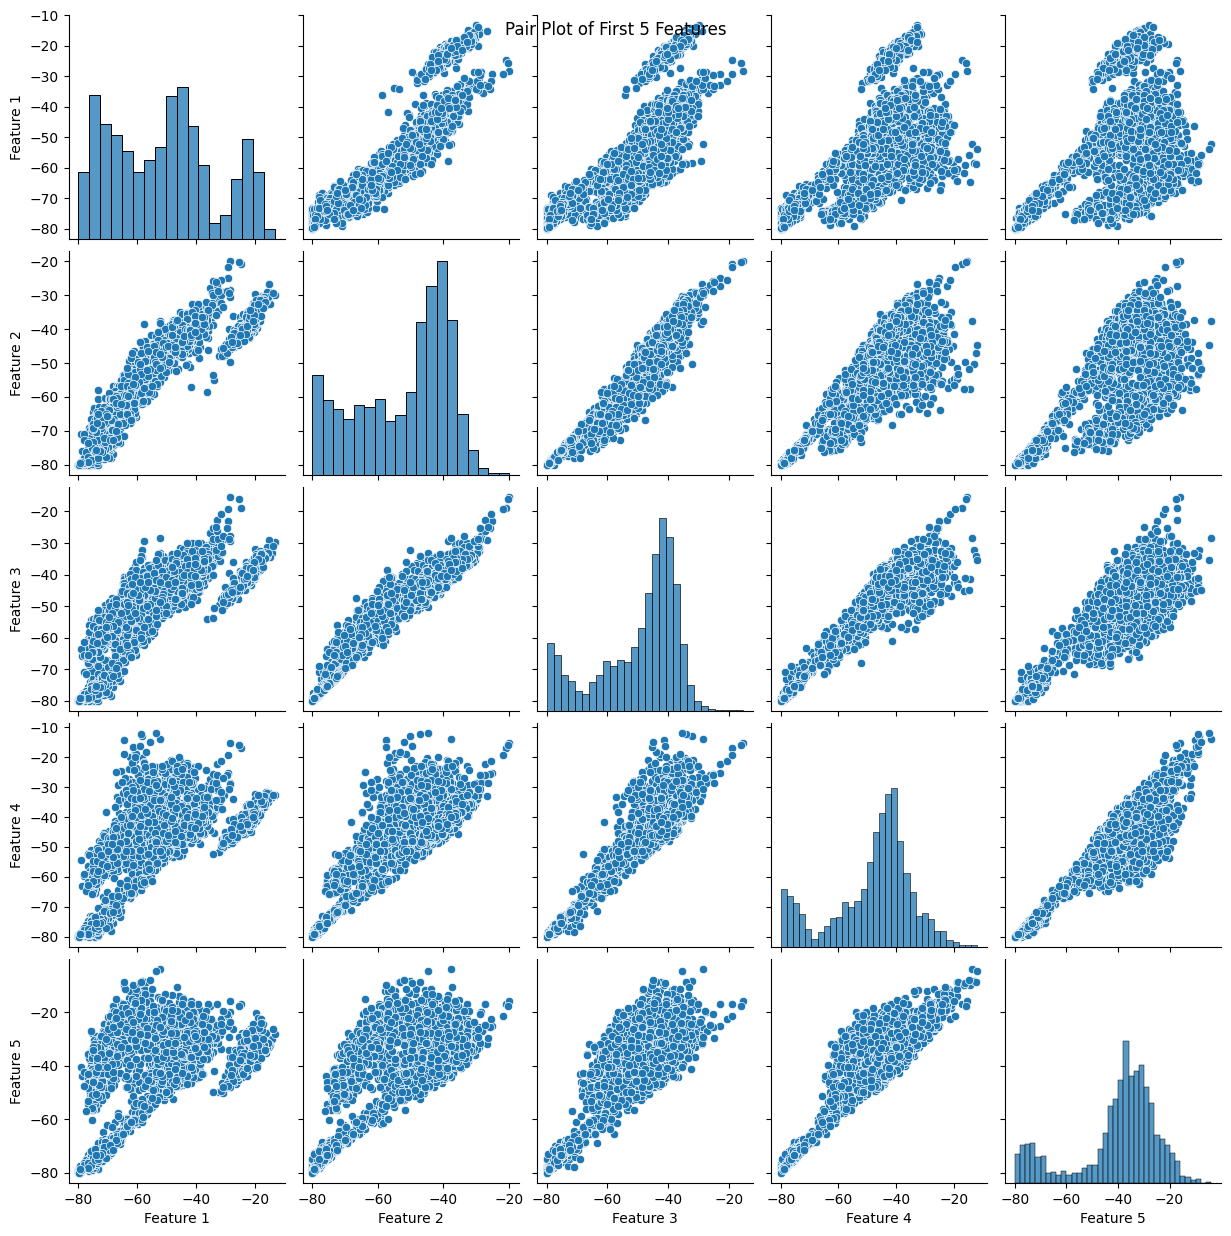

In [15]:
# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df)
plt.suptitle('Pair Plot of First 5 Features')
plt.show()

### Why is dimensionality reduction important?

Some challenges/errors I identified from  the experiment include:

The data in both diagrams appears to be widely spread out, suggesting that some features may be introducing noise and unnecessary complexities which can hinder the model's ability to generalize well. The spread of the data also makes it challenging to identify patterns and extract meaningful insights, which is necessary for effective analysis.

Another challenge I observed from the experiment is multicollinearity, where certain features seem to be highly correlated or repeated. This redundancy can confuse the model, making learning inefficient because it will struggle to differentiate between features and the duplicates(if they truly are).
Additionally, one thing I observed was high variance in values and differences in feature scales. Almost all the features had different ranges, which could lead to model distortion, where certain features dominate over others. This imbalance can negatively impact learning algorithms, making it difficult to achieve optimal performance.


Given these challenges, dimensionality reduction is important because it will help address these problems by eliminating redundancy, reducing noise, and maintaining vital information and patterns. Reducing the dimensionality will improve computational efficiency, making it easier to train and show the hidden patterns and ensuring the model learns effectively.

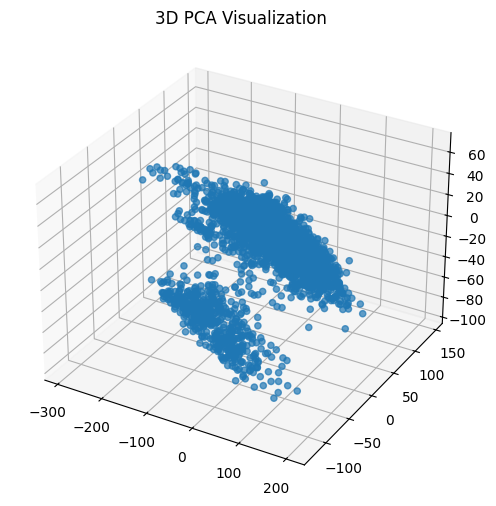

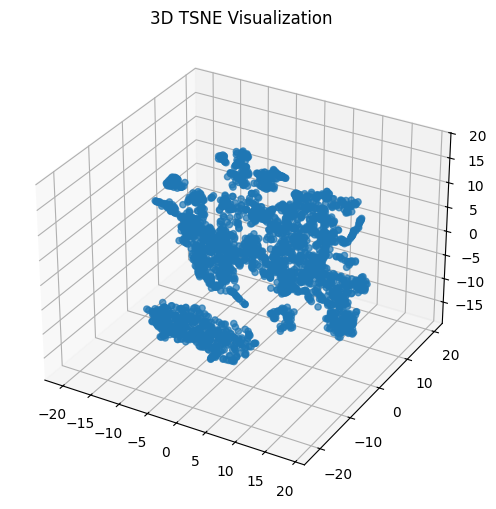

In [16]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax.set_title("3D PCA Visualization")
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax.set_title("3D TSNE Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

The PCA visualizations shows a more spread out distribution of the data points with clear separability between the clusters. The clusters appear to be overlapping. On the other hand, the t-SNE visualization shows more defined clusters with a clear distinction between the different groups even though it also seem to be overlapping at some points. the the t-SNE is more organized compared to the PCA.

From my analysis of this visualization, the t-SNE provides a better separation of clusters because it showed more effectiveness at capturing non-linear structures within the data, shows more distinct clusters.



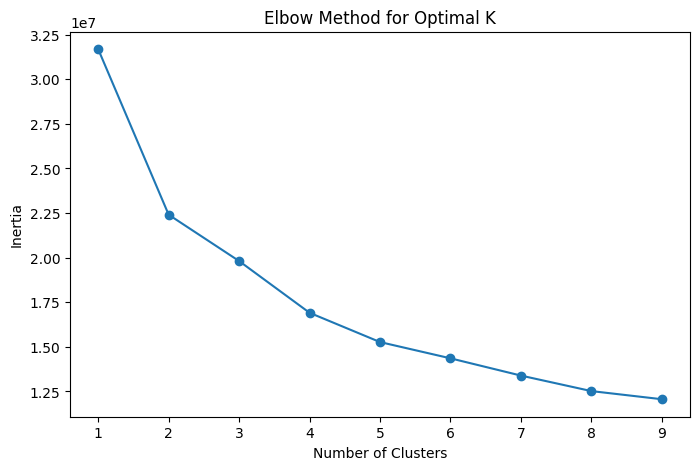

In [17]:
# Optimize number of clusters using Elbow Method

inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

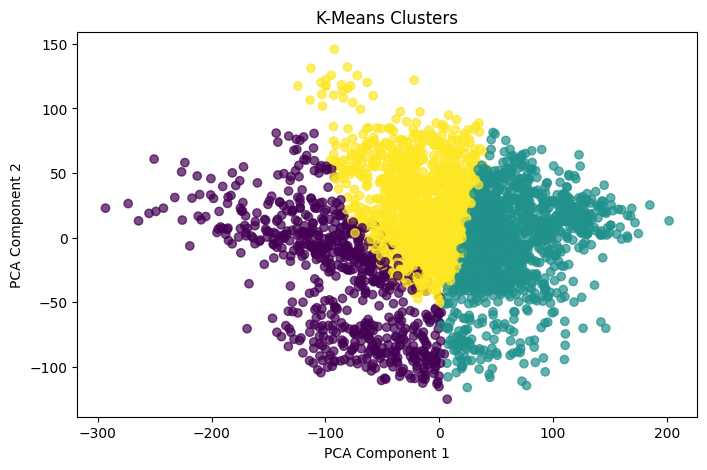

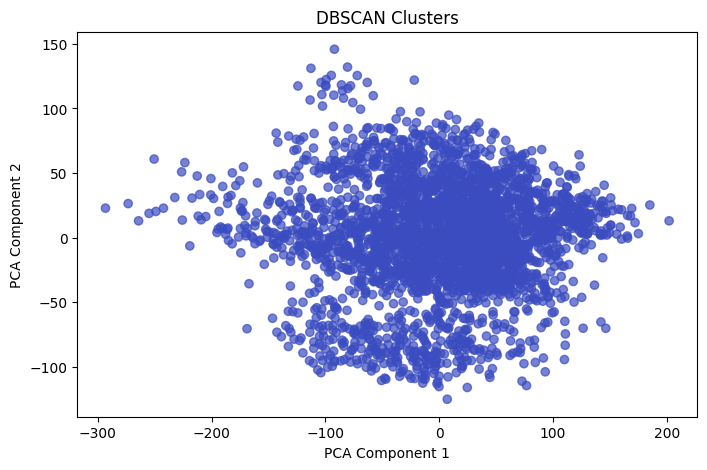

In [18]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters")
plt.show()
print('\n')

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='coolwarm', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clusters")
plt.show()


In [21]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.1741, Davies-Bouldin Index: 1.7984
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
The K-Means clustering achieved a Silhouette Score of 0.1741 and a Davies-Bouldin Index of 1.7984. This indicate a moderate separation between clusters and they have a good distinction even though they are not highly compacted. The plot shows three well defined clusters showing that K-Means was able to structure in the pca data whilst the DBSCAN Clustering failed to form meaningful clusters suggesting that the dataset may have high overlap and varying densities witb it's plot showing just one dense cluster with no clear separation.

In summary, the K-Means performed better than the DBSCAN as evidenced from both the output and the plots.


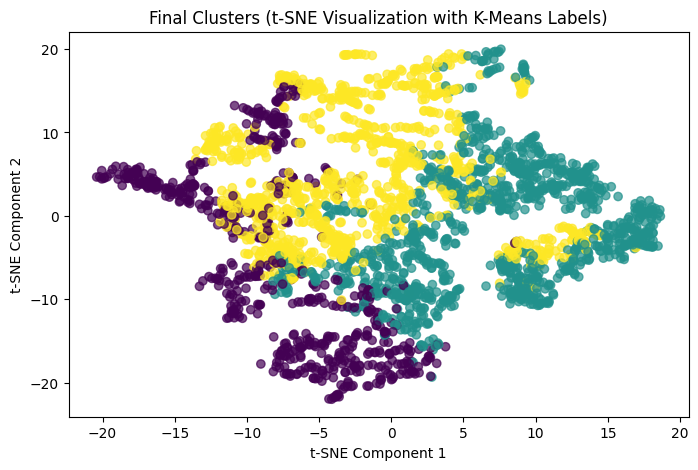

In [24]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.



---



**Dimensionality Reduction** played an important role in the clustering process because initially, the raw features were widely spread out, with overlapping patterns that made it difficult to identify distinct clusters. By applying Principal Component Analysis (PCA) and t-SNE, the high-dimensional data was transformed into a more manageable space, allowing for clearer visualization and better performance of clustering algorithms. This reduction helped the model generalize better, revealed the hidden patterns, reduced noise, improving the model's efficiency.


Among the clustering methods applied, **K-Means** performed better than the DBSCAN. K-Means successfully identified three well-defined clusters, as confirmed by the visualizations. The moderate silhouette score **(0.1741)** and Davies-Bouldin index **(1.7984)** indicated that while the clusters were distinguishable but were not perfectly compact. DBSCAN, on the other hand, failed to form meaningful clusters likely due to the dataset lacking clear density-based separations since DBSCAN is a density-based clustering algorithm.


In **real-world** scenario, audio and speech analysis, sound data is often high-dimensional, noisy (gotten mostly during data collection), and complex, requiring feature extraction and dimensionality reduction for effective clustering. Techniques like PCA and t-SNE help remove redundancy, reduce noise, and highlight meaningful patterns, improving clustering performance. This is also important for applications like **music genre classification, speaker identifications,** and **environmental sound detections**, **voice detection** where uncovering hidden structures will enhance accuracy.